###  <span style="color:red">**This Notebook can be run from Google Colab:**</span>

https://colab.research.google.com

# **<span style="color:red">Background and motivation:</span>**

#### First, we trained a model using positive patches only (only patches actually containing regions corresponding to growing bacterial colonies in the petri-dish), to specifically differentiate among the 8 bacterial species in our dataset. From the confusion matrix of that model, we could see that the model is having difficulty to differentiate between classes 'C1' and 'C2-3' and between classes 'C4-7' and 'C5'.<br>

#### As a next step, we then trained a model to specifically learn to differentiate 'C1' vs 'C2-3' vs 'all_other' classes. This is a model with 3 classes only.<br>

#### Similarly, we also trained a model to specifically learn to differentiate 'C4-7' vs 'C5' vs 'all_other' classes.<br>

#### Last model we trained was a model to specifically differentiate between positive bacterial colony patches (of any class) and negative patches (either petri-dish background, petri-dish border or white image background). For this, we just combined all positive patches (regardless of the bacterial species) in a single 'positive' class and all negative patches in a single 'negative' class.<br> 

#### We then had 4 models, the first one producing 8 predicted probabilities (one for each baterial species), the second one producing 3 predicted probabilities ('C1','C2-3','all_other'), the third one also producing 3 predicted probabilities ('C4-7','C5','all_other') and the fourth one producing 2 predicted probabilities (positive_patch, negative_patch), for a total of 16 predicted probabilities.<br>

#### With those 4 models, using an augmented validation dataset with 9 classes (8 bacterial species + negative_patches), we combined the 16 predicted probabilities as features and y_true, into a training dataset.<br>

#### On this notebook, we now intend to use to train a simple SVM or other simple classification model, to learn to predict either negative or the correct bacterial species, from the probabilities produced by the 4 models above.

In [61]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Let's download the prevously produced training data:**

In [2]:
if 'train_data.csv' not in os.listdir():
    print('Downloading train_data.csv...')
    url = 'https://capstone-fs7.s3.amazonaws.com/train_data.csv'
    urllib.request.urlretrieve(url, 'train_data.csv')
    print('train_data.csv sucessfully downloaded in root dir.')
    
else:
  print("'train_data.csv' was already found on root dir")

print('Root dir content: {}'.format(os.listdir()))

train_data.csv sucessfully downloaded in root dir.
Root dir content: ['.config', 'train_data.csv', 'sample_data']


### **Let's load the donwnloaded csv into a pandas dataframe:**

In [3]:
column_names = [i for i in range(16)] + ['y']
train_df = pd.read_csv('train_data.csv', names = column_names)
print(train_df)

              0         1         2  ...        14        15    y
0      0.680979  0.020416  0.014917  ...  0.948326  0.051674  0.0
1      0.959019  0.004349  0.002977  ...  0.980650  0.019350  0.0
2      0.979188  0.002892  0.002136  ...  0.758641  0.241359  0.0
3      0.953920  0.005291  0.003936  ...  0.041083  0.958917  0.0
4      0.982657  0.002297  0.001645  ...  0.017784  0.982216  0.0
...         ...       ...       ...  ...       ...       ...  ...
59485  0.252584  0.466202  0.034780  ...  0.994676  0.005324  8.0
59486  0.169175  0.093792  0.465270  ...  0.995628  0.004372  8.0
59487  0.993871  0.001962  0.000545  ...  0.994964  0.005036  8.0
59488  0.302604  0.089480  0.046130  ...  0.994312  0.005688  8.0
59489  0.059837  0.126078  0.035875  ...  0.995794  0.004206  8.0

[59490 rows x 17 columns]


### **Let's create training data (X) and target value (y):**

In [4]:
train_df = train_df.sample(frac=1, random_state=0) # shuffle the data
X, y = train_df.drop(columns='y'), train_df['y']
print(X.shape, y.shape)

(59490, 16) (59490,)


### **Let's create a smaller train set for development (X_dev, y_dev):**

In [5]:
train_dev_df = train_df.sample(frac=0.1, random_state=0) # ramdomly select 10% of data for development
X_dev, y_dev = train_dev_df.drop(columns='y'), train_dev_df['y']
print(X_dev.shape, y_dev.shape)

(5949, 16) (5949,)


### **Let's quickly compare kernel SVM vs LinearSVM vs LogisticREgression, with default parameters:**

In [6]:
scaled_svc = make_pipeline(StandardScaler(), SVC())
print('\nScore SVC (non-scaled):', np.mean(cross_val_score(SVC(), X_dev, y_dev, cv=5)))
print('Score Scaled SVC:', np.mean(cross_val_score(scaled_svc, X_dev, y_dev, cv=5)))

scaled_LR = make_pipeline(StandardScaler(), LogisticRegression())
print('\nScore Logistic Regression (non-scaled):', np.mean(cross_val_score(LogisticRegression(), X_dev, y_dev, cv=5)))
print('Score Scaled Logistic Regression:', np.mean(cross_val_score(scaled_LR, X_dev, y_dev, cv=5)))

scaled_LinearSVC = make_pipeline(StandardScaler(), LinearSVC())
print('\nScore LinearSVC (non-scaled):', np.mean(cross_val_score(LinearSVC(), X_dev, y_dev, cv=5)))
print('Score Scaled LinearSVC:', np.mean(cross_val_score(scaled_LinearSVC, X_dev, y_dev, cv=5)))


Score SVC (non-scaled): 0.8846793772707612
Score Scaled SVC: 0.895277704907216

Score Logistic Regression (non-scaled): 0.8930846087331904
Score Scaled Logistic Regression: 0.8940947097480949

Score LinearSVC (non-scaled): 0.8937575896311729
Score Scaled LinearSVC: 0.8940942890184053


#### **All 3 models produced better results when data was scaled**



### **Let's try tuning the 'C' parameter for logistic regression:**

Best Parameter: 
 scaled_LR: {'classifier__C': 568.9866029018299}

Best Score: 
 scaled_LR: 0.8959488989746176



Text(0.5, 1.0, 'Log Regression Scores vs Parameter C')

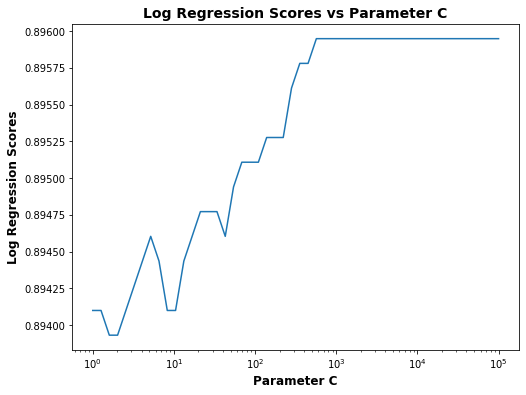

In [0]:
LR_C = np.logspace(0, 5, 50)

# Tune LR parameters using GridSearchCV:
scaled_LR = Pipeline((("preprocess", StandardScaler()),
                      ("classifier", LogisticRegression())))
LR_param_grid = {'classifier__C': LR_C}
scaled_LR_grid = GridSearchCV(scaled_LR, LR_param_grid, cv=5)
scaled_LR_grid.fit(X_dev, y_dev)

print('Best Parameter LR: {}'.format(scaled_LR_grid.best_params_))
print('\nBest Score LR: {}\n'.format(scaled_LR_grid.best_score_))

scaled_LR_scores = scaled_LR_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(LR_C, scaled_LR_scores)
plt.ylabel('Log Regression Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter C', fontsize=12, fontweight='bold')
plt.title('Log Regression Scores vs Parameter C', fontsize=14, fontweight='bold')

### **Let's try tuning the 'C' parameter for kernel SVM:**

Best Parameter SVM: {'classifier__C': 24420.5309454865}
Score SVM: 0.9161203563624138



Text(0.5, 1.0, 'SVM Scores vs Parameter C')

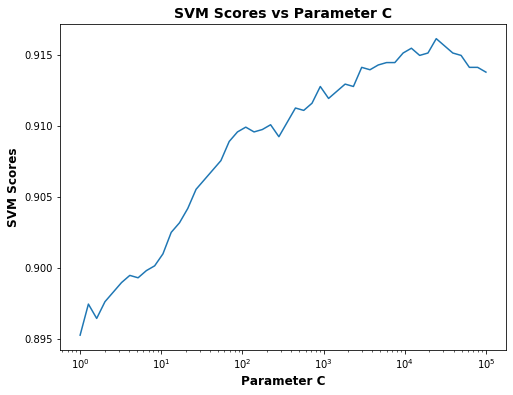

In [0]:
SVM_C = np.logspace(0, 5, 50)

SVM = Pipeline((("preprocess", StandardScaler()),
                ("classifier", SVC(gamma='scale'))))
SVM_param_grid = {'classifier__C': SVM_C}
SVM_grid = GridSearchCV(SVM, SVM_param_grid, cv=5)
SVM_grid.fit(X_dev, y_dev)

print('Best Parameter SVM: {}'.format(SVM_grid.best_params_))
print('Score SVM: {}\n'.format(SVM_grid.best_score_))

SVM_scores = SVM_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(SVM_C, SVM_scores)
plt.ylabel('SVM Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter C', fontsize=12, fontweight='bold')
plt.title('SVM Scores vs Parameter C', fontsize=14, fontweight='bold')

### **Let's try tuning the 'C' parameter for Linear SVM:**

Best Parameter SVM: {'classifier__C': 15.264179671752334}
Score SVM: 0.8951084215834594



Text(0.5, 1.0, 'SVM Scores vs Parameter C')

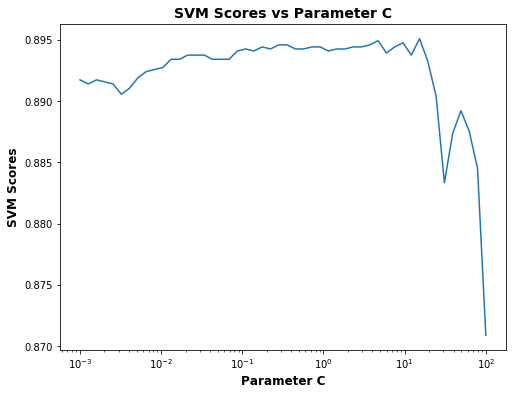

In [0]:
LinearSVM_C = np.logspace(-3, 2, 50)

LinearSVM = Pipeline((("preprocess", StandardScaler()),
                      ("classifier", LinearSVC())))
LinearSVM_param_grid = {'classifier__C': LinearSVM_C}
LinearSVM_grid = GridSearchCV(LinearSVM, LinearSVM_param_grid, cv=5)
LinearSVM_grid.fit(X_dev, y_dev)

print('Best Parameter SVM: {}'.format(LinearSVM_grid.best_params_))
print('Score LinearSVM: {}\n'.format(LinearSVM_grid.best_score_))

LinearSVM_scores = LinearSVM_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(LinearSVM_C, LinearSVM_scores)
plt.ylabel('LinearSVM Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter C', fontsize=12, fontweight='bold')
plt.title('LinearSVM Scores vs Parameter C', fontsize=14, fontweight='bold')

### **Let's test the performance of all 3 models on the entire training dataset:**

In [0]:
LR = scaled_LR_grid.best_estimator_
SVM = SVM_grid.best_estimator_
LinearSVM = LinearSVM_grid.best_estimator_

print("\nScores on the entire training dataset:")

print("\nLR score: {:.4f}".format(LR.score(X, y)))
print("SVM score: {:.4f}".format(SVM.score(X, y)))
print("LinearSVM score: {:.4f}".format(LinearSVM.score(X, y)))


Scores on the entire training dataset:

LR score: 0.893
SVM score: 0.920
LinearSVM score: 0.893


#### **We got better results with kernel SVM, which has more capacity / complexity than the linear models**

### **Let's now try tunning the 'gamma' parameter on the kernel SVM model:**

Best Parameter SVM: {'classifier__gamma': 0.06951927961775606}
Score SVM: 0.9162884518406454

SVM score on entire training data:
 0.9203



Text(0.5, 1.0, 'SVM Scores vs Parameter gamma')

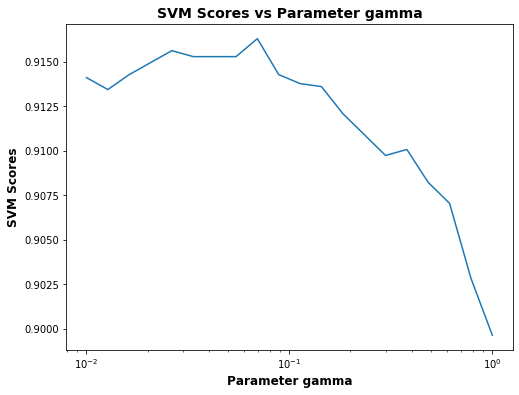

In [58]:
SVM_gamma = np.logspace(-2,0,20)

SVM = Pipeline((("preprocess", StandardScaler()),
                ("classifier", SVC(C=SVM_grid.best_estimator_.get_params('steps')['classifier'].C))))
SVM_param_grid = {'classifier__gamma': SVM_gamma}
SVM_grid = GridSearchCV(SVM, SVM_param_grid, cv=5)
SVM_grid.fit(X_dev, y_dev)

print('Best Parameter SVM: {}'.format(SVM_grid.best_params_))
print('Score SVM: {}\n'.format(SVM_grid.best_score_))

print("SVM score on entire training data:\n {:.4f}\n".format(SVM_grid.best_estimator_.score(X, y)))

SVM_scores = SVM_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(SVM_gamma, SVM_scores)
plt.ylabel('SVM Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter gamma', fontsize=12, fontweight='bold')
plt.title('SVM Scores vs Parameter gamma', fontsize=14, fontweight='bold')

### **Let's train the model on the entire training dataset then save it to GoogleDrive:**

In [0]:
final_model = SVM_grid.best_estimator_.fit(X, y)
dest = 'gdrive/My Drive/Capstone/combine_model_0.9203.sav'
pickle.dump(final_model, open(dest, 'wb'))